# CycleGAN: toy example
This is an toy example that demonstrates CycleGAN and our assumption of semantic correspondence in the color dataset.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools

import matplotlib.pyplot as plt

### Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch, nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(2**21, 3, 1, 1), ratio=0.5, offset=0.2, color=0, std=0):
    '''Generates a random image batch 
    consisting of two modes (dark and light images)
    
    Parameters:
    size (tuple): The dimensions of the image batch (batch_size, channels, width, length)
    ratio (float): The ratio of light to dark images
    offset (float): The brightness of the images relative to black and bright
    color (int): Red = 0, green = 1, blue = 2
    std (float): the standard deviation of the noise in the data set
    
    Returns:
    image_batch (Tensor): The generated image batch
    
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio
    
    m = torch.distributions.normal.Normal(torch.Tensor([0]), torch.ones((int(torch.prod(torch.Tensor(size)))))*std)
    
    image_batch = torch.zeros(size)
    image_batch[:, color] += offset # light color
    image_batch[idx, color] = 1 - offset # dark color 
    
    image_batch += m.sample().view(size)
    return image_batch.clamp(0, 1).cuda()

### The dataset class

In [4]:
class ColorDataset(Dataset):
    '''The dataloader for the color images
    '''
    def __init__(self, ratio=0.5, offset=0.2, color=0, std=0):
        '''  
        Parameters:
        ratio (float): The ratio of light to dark images
        offset (float): The brightness of the images relative to black and bright
        color (int): Red = 0, green = 1, blue = 2
        std (float): the standard deviation of the noise in the data set
        '''
        self.offset = offset
        self.ratio = ratio
        self.color = color
        self.std = std
        
        self.dataset = random_image_data(ratio=self.ratio, 
                                         offset=self.offset, 
                                         color=self.color,
                                         std=self.std)
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 3, 1, 1))

        example_imgs[0, self.color] += self.offset # light color
        example_imgs[1, self.color] = 1 - self.offset # dark color
        return example_imgs

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

### The networks

In [5]:
class Discriminator(nn.Module):
    '''A simple joint discriminator network'''

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out

In [6]:
class Generator(nn.Module):
    '''A simple conditional generator network'''

    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        self.fc2 = nn.Linear(3, 3)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x.view(-1, 3)))
        out = torch.sigmoid(self.fc2(h1))
        return out.unsqueeze(-1).unsqueeze(-1)

### A demonstration of the two domains
The idea here is that we create two domains: A red and a green domain. The domains consist of two modes: dark and light images. The big assumption here for our purpose is that the dark and light images have semantic correspondance, so for example: dark red will be translated to dark green.

We can adjust the intensity of the images (offset) and the ratio of the modes for the experiment. In the visualiztion you can see the elements of the dataset. In the histogram you can see the modes.

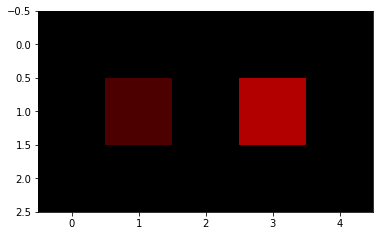

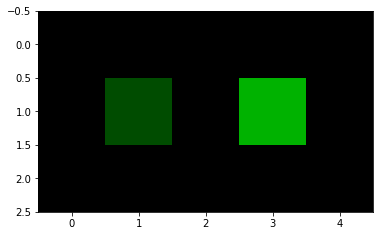

In [7]:
# Settings for domain A (red)
offset_A = 0.3
ratio_A = 0.5
color_A = 0
std_A = 0.03
dataset_A = ColorDataset(offset=offset_A, ratio=ratio_A, color=color_A, std=std_A)
dataloader_A = DataLoader(dataset_A, batch_size=64, shuffle=True)

# Settings for domain B (green)
offset_B = 0.3
ratio_B = 0.2
color_B = 1
std_B = 0.03
dataset_B = ColorDataset(offset=offset_B, ratio=ratio_B, color=color_B, std=std_B)
dataloader_B = DataLoader(dataset_B, batch_size=64, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

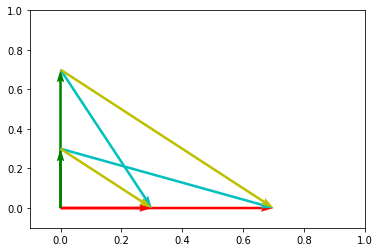

Total distance of cyan   (light to dark, dark to light) 1.523154616355896
Total distance of yellow (light to light, dark to dark) 1.4142135381698608


In [8]:
R = dataset_A.example_imgs[:, :2].squeeze()
G = dataset_B.example_imgs[:, :2].squeeze()
sem1 = torch.stack((R[1], R[0]))-G
sem2 = R-G

plt.quiver([0, 0], [0, 0], R[:, 0], R[:, 1], angles='xy', scale_units='xy', color=['r', 'r'], scale=1)
plt.quiver([0, 0], [0, 0], G[:, 0], G[:, 1], angles='xy', scale_units='xy', color=['g', 'g'], scale=1)
plt.quiver(G[:, 0], G[:, 1], sem1[:, 0], sem1[:, 1], angles='xy', scale_units='xy', color=['c', 'c'], scale=1)
plt.quiver(G[:, 0], G[:, 1], sem2[:, 0], sem2[:, 1], angles='xy', scale_units='xy', color=['y', 'y'], scale=1)

plt.xlim(-0.1, 1)
plt.ylim(-0.1, 1)
plt.show()

print('Total distance of cyan   (light to dark, dark to light)', ((sem1[:, 0]**2 + sem1[:, 1]**2)**0.5).sum().item())
print('Total distance of yellow (light to light, dark to dark)', ((sem2[:, 0]**2 + sem2[:, 1]**2)**0.5).sum().item())

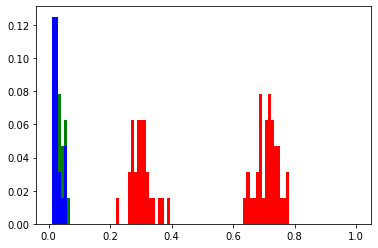

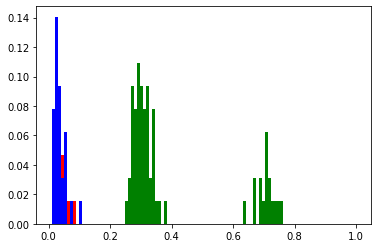

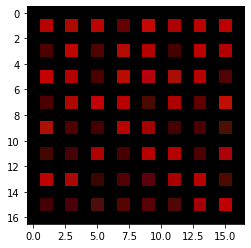

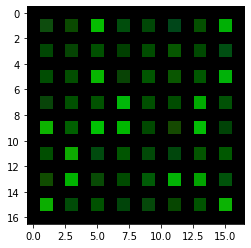

In [9]:
import cv2

def plot_hist(data):
    data = data.permute(1,0,2,3).view(3,-1).cpu()
    for i, c in enumerate(('r', 'g', 'b')):
        plt.hist(data[i], weights=torch.ones(len(data[i]))/len(data[i]), 
                 color=c, bins=100, range= (0.01, 1))
        x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
#     print('True ratio domain A:', dataloader_A.dataset.ratio)
    plot_hist(data_A)
#     print('True ratio domain B:', dataloader_B.dataset.ratio)
    plot_hist(data_B)
    
    visualize_img_batch(data_A[:64].cpu())
    visualize_img_batch(data_B[:64].cpu())
    break

## The training loop

In [10]:
# Initialize the networks
generator_A = Generator().cuda()
generator_B = Generator().cuda()
discriminator_A = Discriminator().cuda()
discriminator_B = Discriminator().cuda()

# Initialize the optimizers
optimizer_g = optim.Adam(itertools.chain(generator_A.parameters(),
                                         generator_B.parameters()), lr=0.01)
optimizer_d = optim.Adam(itertools.chain(discriminator_A.parameters(),
                                         discriminator_B.parameters()), lr=0.01)

# Store values
samples_A = []
samples_B = []

losses_g = []
losses_d = []

criterion_D = nn.MSELoss()
criterion_G = nn.MSELoss()
criterion_cycle = nn.MSELoss()
criterion_L2 = nn.MSELoss()

for epoch in range(1):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
        # Set gradients to zero
        optimizer_d.zero_grad()
        optimizer_g.zero_grad()

        # Forward
        fake_A = generator_A(real_B)
        fake_B = generator_B(real_A)
        
        rec_A = generator_A(fake_B)
        rec_B = generator_B(fake_A)
        
        pred_real_A = discriminator_A(real_A)
        pred_real_B = discriminator_B(real_B)
        
        pred_fake_A = discriminator_A(fake_A.detach())
        pred_fake_B = discriminator_B(fake_B.detach())
        
        # The loss function --------------------------------------------------------------------------------
        loss_D_real_A = criterion_D(pred_real_A, torch.ones((pred_real_A.shape)).cuda())
        loss_D_real_B = criterion_D(pred_real_B, torch.ones((pred_real_B.shape)).cuda())

        loss_D_fake_A = criterion_D(pred_fake_A, torch.zeros((pred_fake_A.shape)).cuda())
        loss_D_fake_B = criterion_D(pred_fake_B, torch.zeros((pred_fake_B.shape)).cuda())
        
        loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
        
        loss_G_A = criterion_G(discriminator_A(fake_A), torch.ones((pred_fake_A.shape)).cuda())
        loss_G_B = criterion_G(discriminator_B(fake_B), torch.ones((pred_fake_A.shape)).cuda())
        
        cycle_A = criterion_cycle(real_A, rec_A)
        cycle_B = criterion_cycle(real_B, rec_B)
        cycle = cycle_A + cycle_B
        
        loss_d = (loss_D_A + loss_D_B)
        loss_g = (loss_G_A + loss_G_B) + cycle
        # ---------------------------------------------------------------------------------------------------

        # Backward
        loss_g.backward()
        loss_d.backward()

        # Optimization step
        optimizer_g.step()
        optimizer_d.step()

        # Store values --------------------------------------------------------------------------------------
        losses_g += [loss_g.item()]
        losses_d += [loss_d.item()]
        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            samples_A += [fake_A.detach()]
            samples_B += [fake_B.detach()]
            print('step', i, 'loss_g', loss_g.item(), 'loss_d', loss_d.item())

step 0 loss_g 1.073659062385559 loss_d 0.5468711256980896
step 500 loss_g 0.1466931402683258 loss_d 0.6255435943603516
step 1000 loss_g 0.1253420114517212 loss_d 0.6257507801055908
step 1500 loss_g 0.1271659880876541 loss_d 0.6228002309799194
step 2000 loss_g 0.1266779601573944 loss_d 0.6244643926620483
step 2500 loss_g 0.12603585422039032 loss_d 0.6244192123413086
step 3000 loss_g 0.12610287964344025 loss_d 0.6274902820587158
step 3500 loss_g 0.12575654685497284 loss_d 0.6242977976799011
step 4000 loss_g 0.1252373456954956 loss_d 0.6255871057510376
step 4500 loss_g 0.1262943297624588 loss_d 0.6258447170257568
step 5000 loss_g 0.1252872496843338 loss_d 0.6256450414657593
step 5500 loss_g 0.1256912797689438 loss_d 0.6252201199531555
step 6000 loss_g 0.12607476115226746 loss_d 0.6239893436431885
step 6500 loss_g 0.12594643235206604 loss_d 0.6248747110366821
step 7000 loss_g 0.12509113550186157 loss_d 0.625734806060791
step 7500 loss_g 0.12500502169132233 loss_d 0.6259161233901978
step 80

KeyboardInterrupt: 

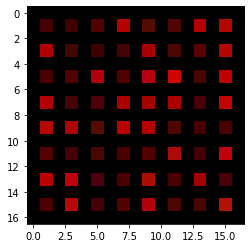

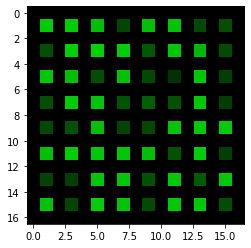

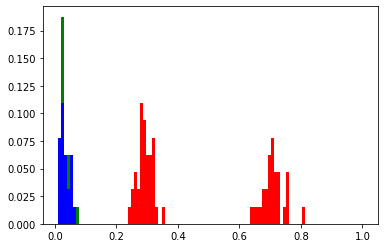

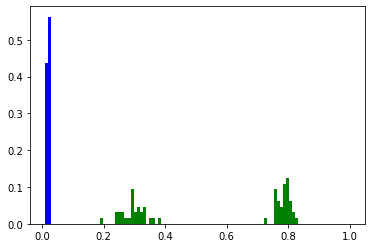

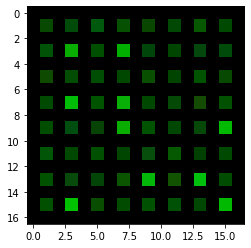

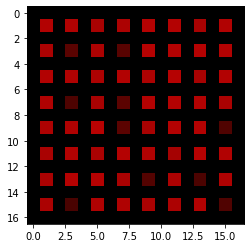

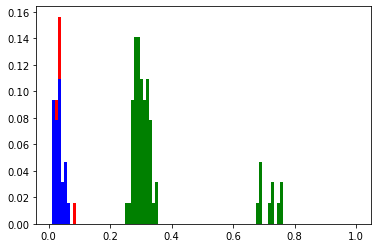

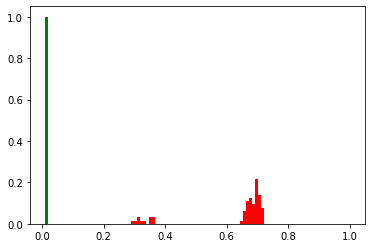

In [11]:
# Some generated images
visualize_img_batch(real_A.detach()[:64].cpu())
visualize_img_batch(fake_B.detach()[:64].cpu())
plot_hist(real_A.detach().cpu())
plot_hist(fake_B.detach().cpu())

visualize_img_batch(real_B.detach()[:64].cpu())
visualize_img_batch(fake_A.detach()[:64].cpu())
plot_hist(real_B.detach().cpu())
plot_hist(fake_A.detach().cpu())

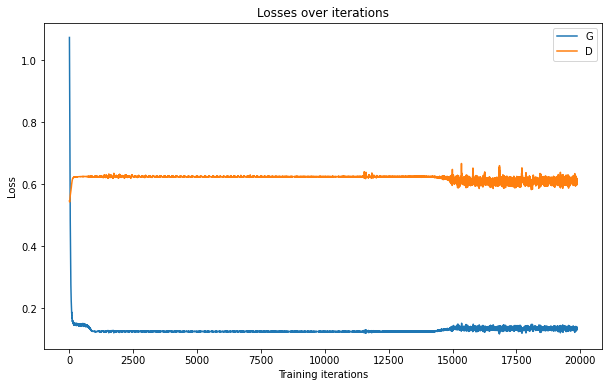

In [14]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(losses_g)
plt.plot(losses_d)
plt.legend(['G', 'D'])
plt.show()

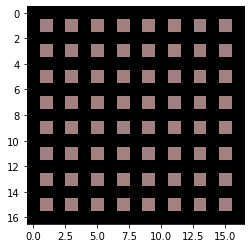

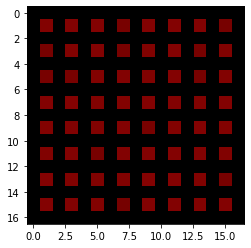

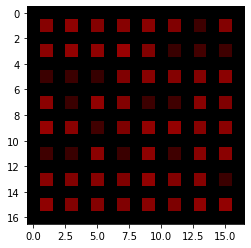

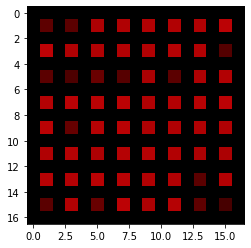

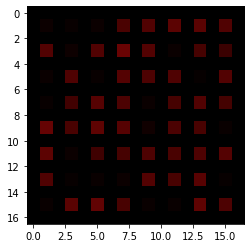

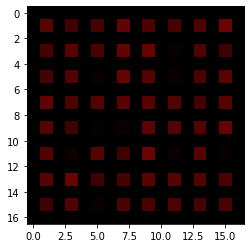

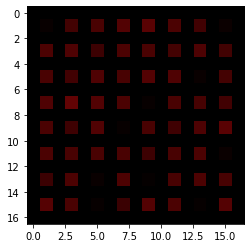

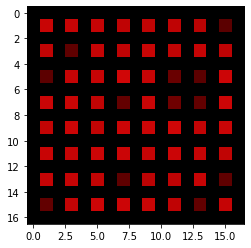

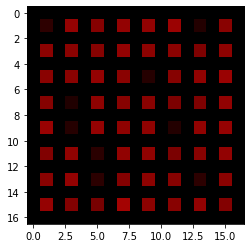

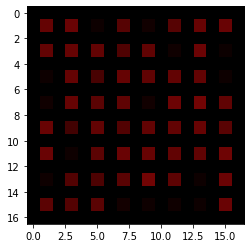

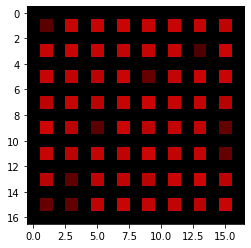

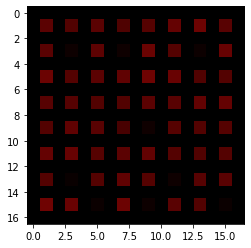

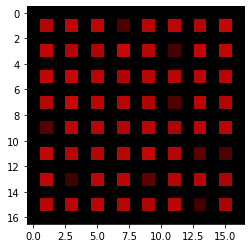

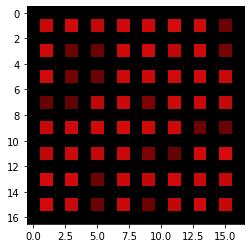

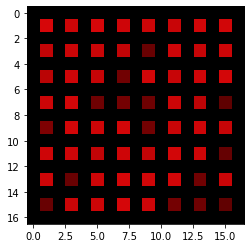

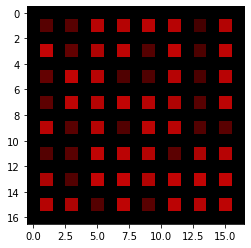

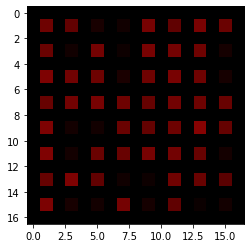

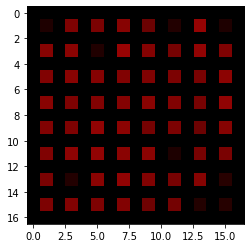

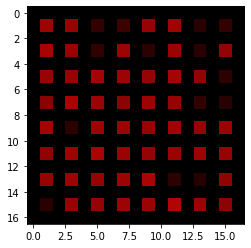

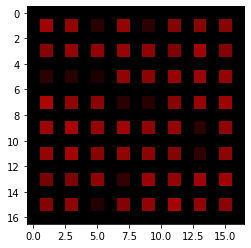

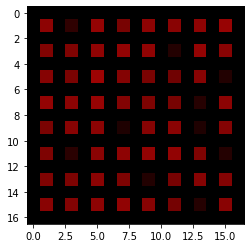

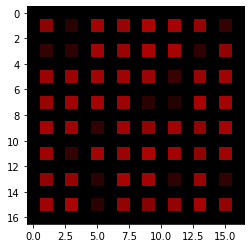

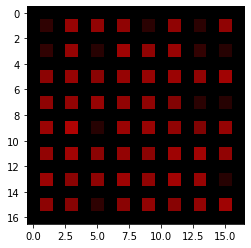

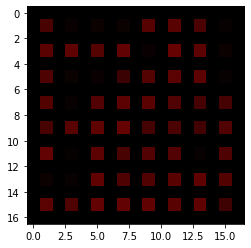

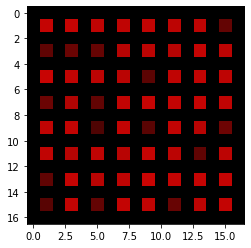

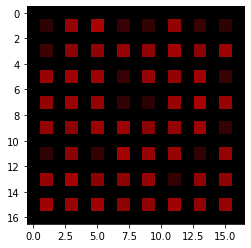

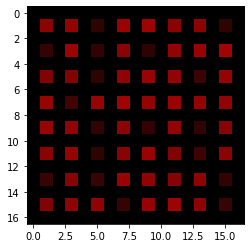

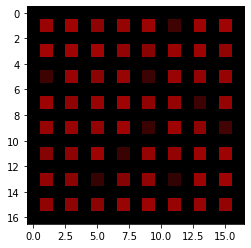

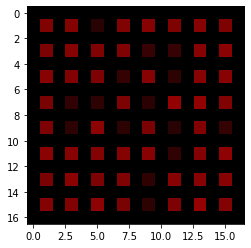

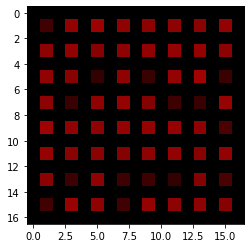

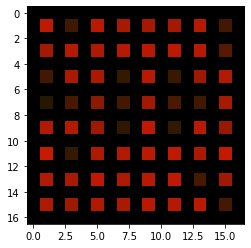

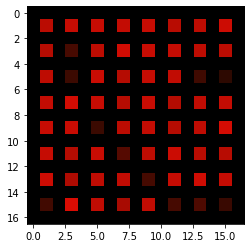

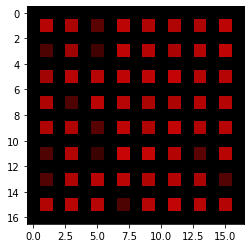

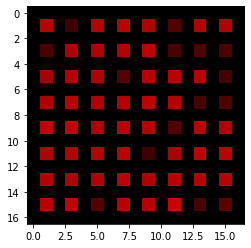

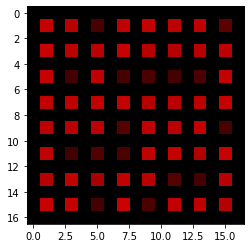

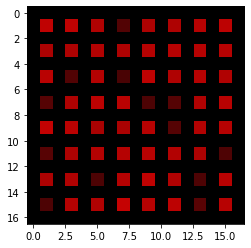

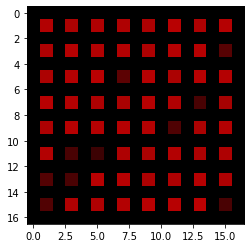

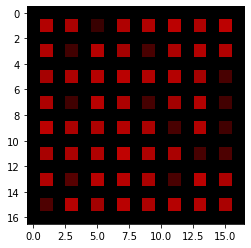

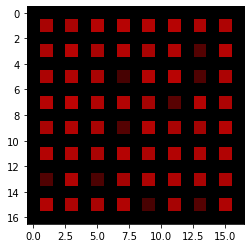

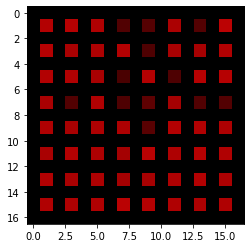

In [15]:
for img in samples_A:
    visualize_img_batch(img[:64].cpu())